# Pytorch运用

通过示例进一步理解如何运用pytorch包，目前主要是记录基本的ann/rnn/cnn。

## 基本神经网络

简单复习下步骤：

获取数据，包括归一化处理—>构建神经网络结果，主要是定义layer，完成参数初始化—>定义forward函数，主要是每层计算输出，包括定义激活函数—>定义损失函数、优化算法—>注意要先将数据定义到张量中，然后调用函数式地调用神经网络对象以调用forward计算—>计算loss并由loss张量完成自动梯度计算反向传播—>调用优化算法的step完成参数更新—>梯度归零（也可以放在loss反向传播之前），开始新一轮循环参数更新。

上述步骤中，除了重写Module之外，直接利用Sequential构建神经网络结构也是一种常见做法。

接下来利用pytorch写一个神经网络的示例来自课程《Mordern deep learning in Python》。

Reading in and transforming data...


C:\Users\hust2\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 0, cost: 0.251691, acc: 0.96
Epoch: 1, cost: 0.117666, acc: 0.97
Epoch: 2, cost: 0.082470, acc: 0.97
Epoch: 3, cost: 0.054635, acc: 0.97
Epoch: 4, cost: 0.060924, acc: 0.97
Epoch: 5, cost: 0.052717, acc: 0.97
Epoch: 6, cost: 0.039973, acc: 0.98
Epoch: 7, cost: 0.034754, acc: 0.97
Epoch: 8, cost: 0.044111, acc: 0.98
Epoch: 9, cost: 0.050160, acc: 0.98
Epoch: 10, cost: 0.031708, acc: 0.98
Epoch: 11, cost: 0.042624, acc: 0.98
Epoch: 12, cost: 0.030264, acc: 0.98
Epoch: 13, cost: 0.032563, acc: 0.98
Epoch: 14, cost: 0.027656, acc: 0.98


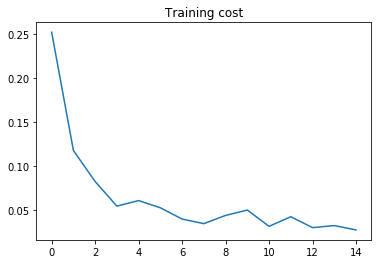

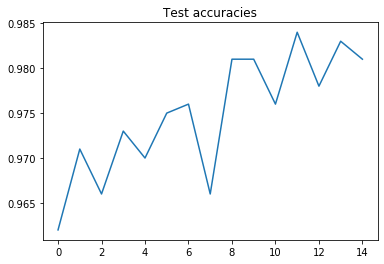

In [3]:
import os
import pandas as pd
import numpy as np


def get_normalized_data():
    """获取数据"""
    print("Reading in and transforming data...")

    if not os.path.exists('data/mnist/train.csv'):
        print('Looking for data/mnist/train.csv')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
        print('Place train.csv in the folder data adjacent to the class folder')
        exit()

    df = pd.read_csv('data/mnist/train.csv')
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest = X[-1000:]
    Ytest = Y[-1000:]

    # normalize the data
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)
    np.place(std, std == 0, 1)
    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std

    return Xtrain, Xtest, Ytrain, Ytest

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch import optim
import torch

# 第一步是load data，这里采用的是deep learning里的hello world，即识别手写数字的数据集，来自kaggle。
# get the data,
# no need to split now, the fit() function will do it
Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()

# get shapes
_, D = Xtrain.shape
K = len(set(Ytrain))

# 第二步是构建网络结构，使用pytorch构建神经网络要比直接通过numpy手写简单很多，这里先构建一个sequential（和Keras类似），然后逐层添加网络结构即可。
model = torch.nn.Sequential()
# 逐层添加网络即可，在pytorch中是采用add_module()函数。第一个参数是当前层的命名，可以取任何想要的名称。第二个参数就是该层。层要么是linear transformation，要么是activation
# 比如第一层，Linear,参数D是输入的神经元个数，第二个参数500是输出的神经元个数
model.add_module("dense1", torch.nn.Linear(D, 500))
model.add_module("relu1", torch.nn.ReLU())
model.add_module("dense2", torch.nn.Linear(500, 300))
model.add_module("relu2", torch.nn.ReLU())
model.add_module("dense3", torch.nn.Linear(300, K))
# 第三步是构建loss函数，loss函数详情可参考http://pytorch.org/docs/master/nn.html#loss-functions
loss = torch.nn.CrossEntropyLoss(size_average=True)
# 第四步是设置优化函数，Adam是一种常用的优化算法，是一种改良的GD算法。算法需要神经网络的parameters作为参数。
optimizer = optim.Adam(model.parameters())


# 第五步是定义训练过程和预测过程，这部分也是相对最难掌握的一部分。这部分相对TensorFlow和Theano都会麻烦一些。


def train(model, loss, optimizer, inputs, labels):
    """训练过程主要包括：包装输入输出到Variable变量，初始化优化函数，前向传播，反向传播，以及参数更新，详情见每步解释"""
    # 为什么要包装变量到Variable：把Tensor包装到Variable中，它就会开始保存所有计算历史。因此每次运算都会稍微多一些cost；另一方面，在训练循环外部对Variable进行计算操作相对容易。不包装也是可以计算的，并且后面的pytorch版本有柯南高就不需要Variable的这一步了
    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    # pytorch的梯度计算是累计的，这对有些神经网络是比较好的，因此这里初始化为0
    optimizer.zero_grad()

    # 直接调用model的前向函数即可得到输出
    logits = model.forward(inputs)

    # 然后计算loss
    output = loss.forward(logits, labels)

    # 接着就是进行反向传播计算
    output.backward()

    # 最后是更新参数
    optimizer.step()

    return output.item()


def predict(model, inputs):
    inputs = Variable(inputs, requires_grad=False)
    logits = model.forward(inputs)
    # argmax函数是给出axis维上数组中最大数的索引
    return logits.data.numpy().argmax(axis=1)


# 第六步定义各类超参数并开始训练过程
# 首先是将numpy变量都设置为torch中的张量，注意要指定数据类型
Xtrain = torch.from_numpy(Xtrain).float()
Ytrain = torch.from_numpy(Ytrain).long()
Xtest = torch.from_numpy(Xtest).float()

epochs = 15
batch_size = 32  # 每个batch的大小
n_batches = Xtrain.size()[0] // batch_size  # batch的个数

costs = []
test_accuracies = []
for i in range(epochs):
    cost = 0.
    for j in range(n_batches):
        Xbatch = Xtrain[j * batch_size:(j + 1) * batch_size]
        Ybatch = Ytrain[j * batch_size:(j + 1) * batch_size]
        cost += train(model, loss, optimizer, Xbatch, Ybatch)

    Ypred = predict(model, Xtest)
    acc = np.mean(Ytest == Ypred)
    print("Epoch: %d, cost: %f, acc: %.2f" % (i, cost / n_batches, acc))

    costs.append(cost / n_batches)
    test_accuracies.append(acc)

# 第七步是将训练过程可视化,# EXERCISE: plot test cost + training accuracy too。一般都是把cost和accuracy都可视化出来
# plot the results
plt.plot(costs)
plt.title('Training cost')
plt.show()

plt.plot(test_accuracies)
plt.title('Test accuracies')
plt.show()

在模型训练中，dropout是个比较重要的环节，以下给出一个示例。

有dropout的神经网络的区别：
一个是在神经网络结构中增加dropout层；
另一个，注意dropout有两个mode，一是对train data的，一个是对test data的。在train data中进行dropout，但是在test data中是不用的"""

In [ ]:
# https://deeplearningcourses.com/c/data-science-deep-learning-in-theano-tensorflow
# https://www.udemy.com/data-science-deep-learning-in-theano-tensorflow
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

# Note: is helpful to look at keras_example.py first


import numpy as np
import matplotlib.pyplot as plt
from util import get_normalized_data

import torch
from torch.autograd import Variable
from torch import optim

# get the data, same as Theano + Tensorflow examples
# no need to split now, the fit() function will do it
Xtrain, Xtest, Ytrain, Ytest = get_normalized_data()

# get shapes
_, D = Xtrain.shape
K = len(set(Ytrain))

# Note: no need to convert Y to indicator matrix


# the model will be a sequence of layers
model = torch.nn.Sequential()

# ANN with layers [784] -> [500] -> [300] -> [10]
# NOTE: the "p" is p_drop, not p_keep
model.add_module("dropout1", torch.nn.Dropout(p=0.2))
model.add_module("dense1", torch.nn.Linear(D, 500))
model.add_module("relu1", torch.nn.ReLU())
model.add_module("dropout2", torch.nn.Dropout(p=0.5))
model.add_module("dense2", torch.nn.Linear(500, 300))
model.add_module("relu2", torch.nn.ReLU())
model.add_module("dropout3", torch.nn.Dropout(p=0.5))
model.add_module("dense3", torch.nn.Linear(300, K))
# Note: no final softmax!
# just like Tensorflow, it's included in cross-entropy function


# define a loss function
# other loss functions can be found here:
# http://pytorch.org/docs/master/nn.html#loss-functions
loss = torch.nn.CrossEntropyLoss(size_average=True)
# Note: this returns a function!
# e.g. use it like: loss(logits, labels)


# define an optimizer
# other optimizers can be found here:
# http://pytorch.org/docs/master/optim.html
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# define the training procedure
# i.e. one step of gradient descent
# there are lots of steps
# so we encapsulate it in a function
# Note: inputs and labels are torch tensors
def train(model, loss, optimizer, inputs, labels):
    # set the model to training mode
    # because dropout has 2 different modes!
    model.train()

    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    logits = model.forward(inputs)
    output = loss.forward(logits, labels)

    # Backward
    output.backward()

    # Update parameters
    optimizer.step()

    # what's the difference between backward() and step()?

    return output.item()


# similar to train() but not doing the backprop step
def get_cost(model, loss, inputs, labels):
    # set the model to testing mode
    # because dropout has 2 different modes!
    model.eval()

    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)

    # Forward
    logits = model.forward(inputs)
    output = loss.forward(logits, labels)

    return output.item()


# define the prediction procedure
# also encapsulate these steps
# Note: inputs is a torch tensor
def predict(model, inputs):
    # set the model to testing mode
    # because dropout has 2 different modes!
    model.eval()

    inputs = Variable(inputs, requires_grad=False)
    logits = model.forward(inputs)
    return logits.data.numpy().argmax(axis=1)


# return the accuracy
# labels is a torch tensor
# to get back the internal numpy data
# use the instance method .numpy()
def score(model, inputs, labels):
    predictions = predict(model, inputs)
    return np.mean(labels.numpy() == predictions)


### prepare for training loop ###

# convert the data arrays into torch tensors
Xtrain = torch.from_numpy(Xtrain).float()
Ytrain = torch.from_numpy(Ytrain).long()
Xtest = torch.from_numpy(Xtest).float()
Ytest = torch.from_numpy(Ytest).long()

# training parameters
epochs = 15
batch_size = 32
n_batches = Xtrain.size()[0] // batch_size

# things to keep track of
train_costs = []
test_costs = []
train_accuracies = []
test_accuracies = []

# main training loop
for i in range(epochs):
    cost = 0
    test_cost = 0
    for j in range(n_batches):
        Xbatch = Xtrain[j * batch_size:(j + 1) * batch_size]
        Ybatch = Ytrain[j * batch_size:(j + 1) * batch_size]
        cost += train(model, loss, optimizer, Xbatch, Ybatch)

    # we could have also calculated the train cost here
    # but I wanted to show you that we could also return it
    # from the train function itself
    train_acc = score(model, Xtrain, Ytrain)
    test_acc = score(model, Xtest, Ytest)
    test_cost = get_cost(model, loss, Xtest, Ytest)

    print("Epoch: %d, cost: %f, acc: %.2f" % (i, test_cost, test_acc))

    # for plotting
    train_costs.append(cost / n_batches)
    train_accuracies.append(train_acc)
    test_costs.append(test_cost)
    test_accuracies.append(test_acc)

# plot the results
plt.plot(train_costs, label='Train cost')
plt.plot(test_costs, label='Test cost')
plt.title('Cost')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train accuracy')
plt.plot(test_accuracies, label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## LSTM in Torch

在前述基本神经网络构建的基础上，现在来讨论循环神经网络的使用。

pytorch中，LSTM类继承自RNNBase类，RNNBase类继承自Module类，Module类是pytorch中完成一定网络功能的基类，可以通过继承该类定义自己的神经网络。自己实现神经网络时，一般要重写其forward方法。

Module实现了__call__方法，这意味着其可被当做可调用方法使用。比如下面有用到lstm()。

In [ ]:
"""一个简单的pytorch的lstm模型的示例"""
# Author: Robert Guthrie

import torch
import torch.autograd as autograd  # torch中自动计算梯度模块
import torch.nn as nn             # 神经网络模块
import torch.nn.functional as F   # 神经网络模块中的常用功能
import torch.optim as optim       # 模型优化器模块

torch.manual_seed(1)

lstm = nn.LSTM(3, 3)
# 生成一个长度为5，每一个元素为1*3的序列作为输入，这里的数字3对应于上句中第一个3
inputs = [autograd.Variable(torch.randn((1, 3))) for _ in range(5)]

# 设置隐藏层维度，初始化隐藏层的数据。hidden变量是一个元组，其第一个元素是LSTM隐藏层输出，另一个元素维护隐藏层的状态。
# torch.rand(1,1,3)就是生成了一个维度为(1,1,3)的以一定高斯分布生成的张量
hidden = (autograd.Variable(torch.randn(1, 1, 3)),
          autograd.Variable(torch.randn((1, 1, 3))))

for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    print(out)
    print(hidden)

- [] CNN in pytorch